# Training a wind turbine detection model using large volumes of training data

* 🔬 Data Science
* 🥠 Deep Learning and Object Detection

## Table of Contents
* [Introduction](#Introduction)
* [Export training data](#Export-Training-Data) or [Download sample training data](#Download-sample-training-data-optional)
* [Model training](#Model-Training)
 * [Executing model training script](#Executing-model-training-script)
 * [Monitor model training](#Monitor-model-training)
* [Model inference](#Model-inference)
* [Conclusion](#Conclusion)

## Introduction

When training robust deep learning models, large amounts of training data is usually required. Unfortunately, large volumes of data can often be difficult to manage and process. To reduce the effort required to export training data and train a model, we can distribute the workload to different processes, or even different machines altogether.

In this workflow, we will perform three broad steps.

- Exporting or downloading the training data.
- Training the model.
- Deploying the model and extracting its footprints.

This workflow requires deep learning dependencies to be installed. Documentation is available [here](https://developers.arcgis.com/python/guide/install-and-set-up/) for installing and setting up an appropriate environment.

## Export Training Data

We will be using the ['Export Training Data for Deep Learning'](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/export-training-data-for-deep-learning.htm) tool to export the training data.

Imagery and Data Sources:
- Imagery: NAIP Imagery downloaded [here](https://nrcs.app.box.com/v/naip).
- labels: The U.S. Wind Turbine Database downloaded [here](https://eerscmap.usgs.gov/uswtdb/assets/data/uswtdbSHP.zip).

Here, we have multiple rasters and a label file. We will prepare a list of arguments and a map with `arcpy.ia.ExportTrainingDataForDeepLearning`. In this sample, we are distributing processing per image. However, in cases with larger rasters, we can further split the rasters to parts and distribute the processing across various windows on the raster.

```python
# Imports
import arcpy
from glob import glob
from multiprocessing.pool import Pool
import os

# Prepare a list of Images
rasters = glob(r'c:\data\imagery\**\*.sid')
print(f"-- Found {len(rasters)} rasters")

# other parameters
lbl_shp = r'c:\data\labels\uswtdbSHP\uswtdb_v4_0_20210409_buffer_25m.shp'
tile_size = 400
cell_size = 0.6
output_path = r"c:\data\exported_training_data"

# Prepare arguments list
arglist = []
for idx, raster in enumerate(rasters):
    outpath = os.path.join(output_path, os.path.basename(raster)[:4])
    arglist.append((
        raster,
        outpath,
        lbl_shp,
        "TIFF",
        tile_size,
        tile_size,
        0,
        0,
        "ONLY_TILES_WITH_FEATURES",
        "PASCAL_VOC_rectangles",
        0,
        None,
        0,
        None,
        0,
        "MAP_SPACE",
        "PROCESS_AS_MOSAICKED_IMAGE",
        "NO_BLACKEN",
        "FIXED_SIZE"
    ))
    
# Export training data using multiprocessing
nprocesses = os.cpu_count() - 1
print(f"-- using {nprocesses} Processes")
my_pool = Pool(nprocesses)
res = my_pool.imap_unordered(arcpy.ia.ExportTrainingDataForDeepLearning, arglist)
for i, val in enumerate(res):
    print(f"--Progress: {i}/{len(arglist)} Rasters | {(i*100/len(arglist)):0.2f} % |             ", end='\r')
print("-- Done")
my_pool.close()
my_pool.join()
del my_pool
```

This will create all of the files necessary for the next step in the 'Output Path'. These files will serve as our training data.

**You can either create a python script with the content above or download a sample using the ArcGIS Python API, as shown below.**

In [1]:
from arcgis.gis import GIS
gis = GIS('home')

<Item title:"export_training_data_py" type:Code Sample owner:api_data_owner>
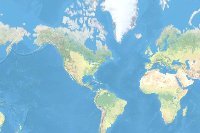

In [2]:
exporting_script = gis.content.get('e105f94a25604b798b96495b89c6877f')
exporting_script

In [3]:
import zipfile
from pathlib import Path
zpath = exporting_script.download(file_name=exporting_script.name)
with zipfile.ZipFile(zpath, 'r') as zip_ref:
    zip_ref.extractall('.')

## Download sample training data optional

Alternatively, you can also directly get a sample of exported training data, as shown below.

In [5]:
from arcgis.gis import GIS
gis = GIS('home')

In [4]:
training_data = gis.content.get('bc846c5999cd44efaeafcdce3ae1ddf5')
training_data

<Item title:"wind_turbines_usa_sample" type:Image Collection owner:api_data_owner>

In [5]:
filepath = training_data.download(file_name=training_data.name)

In [8]:
import zipfile
from pathlib import Path
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)
#
output_path = str(Path(filepath).parent / 'wind_turbines')

In [15]:
print(output_path)

C:\Users\user\AppData\Local\Temp\wind_turbines


## Model Training

When working with large volumes of training data, it is recommended that you use distributed training if multiple GPUs are available to you. This process can be done using a python script, as shown below.

```python
# Imports
from arcgis.learn import prepare_data, FasterRCNN
from glob import glob
import os

# Load training data
training_data_path = r"c:\data\exported_training_data"
data_folders = glob(os.path.join(training_data_path, '**'))
data = prepare_data(
    data_folders, 
    batch_size=16, 
    chip_size=400)

# Train model
model = FasterRCNN(data)
model.fit(10, .001, tensorboard=True)
model.save('wind_turbine_model_10epochs')
```

**You can either create a python script with the content above or download a sample using the ArcGIS Python API, as shown below.**

In [5]:
from arcgis.gis import GIS
gis = GIS('home')

In [6]:
training_script = gis.content.get('3a0e7754a29c4bf19eadffc3d08e5f23')
training_script

<Item title:"train_wind_turbine_model_py" type:Code Sample owner:api_data_owner>

In [6]:
import zipfile
from pathlib import Path
zpath = training_script.download(file_name=training_script.name)
with zipfile.ZipFile(zpath, 'r') as zip_ref:
    zip_ref.extractall('.')

### Executing model training script

Once you have the script ready, you can execute it as documented below.

```bash
python -m torch.distributed.launch --nproc_per_node=<number-of-GPUs> train_wind_turbine_model.py
```

 **Important!** Replace `<number-of-GPUs>` with an integer value representing the optimal number of GPU's you want to utilize.

Learn more about the torch distributed launch module in the pytorch documentation [here](https://pytorch.org/docs/1.8.1/distributed.html#launch-utility)

### Monitor model training

While the model is training, we can monitor the performance of the model using tensorboard. 

To start monitoring with tensorboard, we need to execute the related command printed by the model training script.

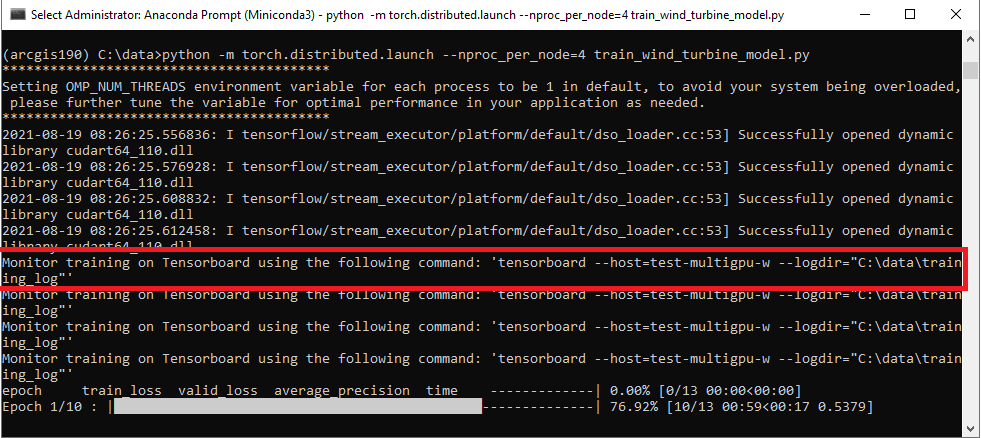

```bash
tensorboard --host=test-multigpu-w --logdir="C:\data\training_log"
```
We will execute this command in a separate anaconda prompt.

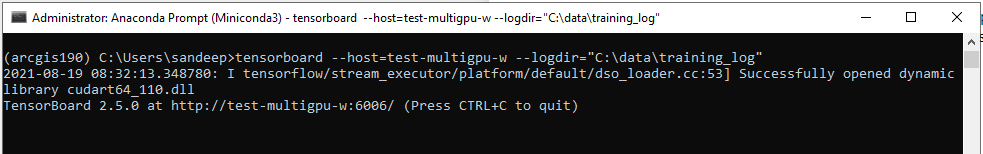

Once executed, we need to Launch the tensorboard monitor in a browser by visiting the printed URL. The tensorboard monitor will look like the following image:

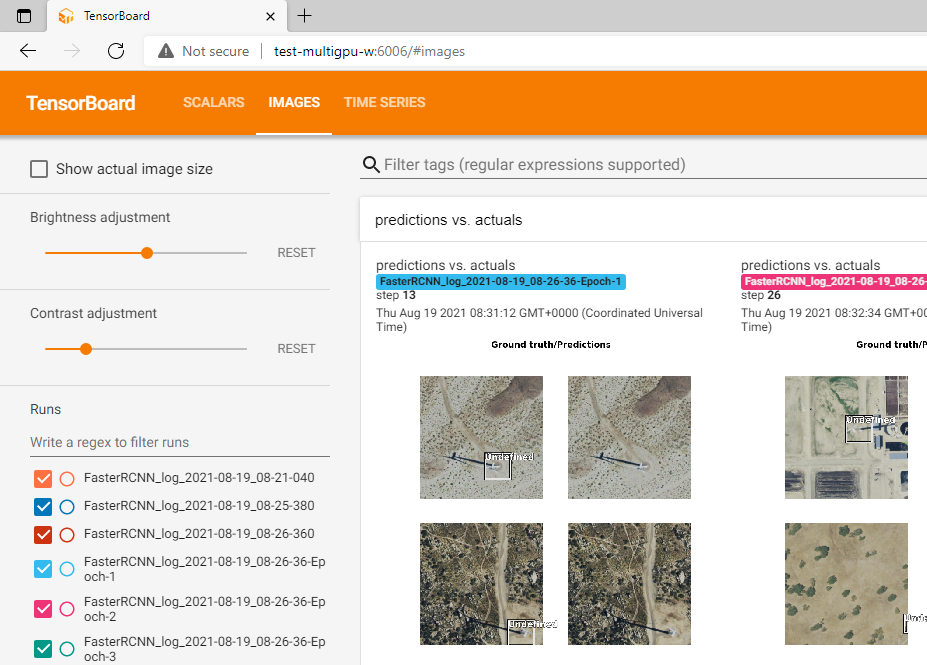

For more information about tensorboard support in ArcGIS Python API, you can follow [this guide](https://developers.arcgis.com/python/guide/monitor-model-training-with-tensorboard/).

## Model inference

We will find the model saved in the 'models' folder. The saved model can be used to detect wind turbines using the [Detect Objects Using Deep Learning](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/detect-objects-using-deep-learning.htm) tool, available in both [ArcGIS Pro](https://www.esri.in/en-in/products/arcgis-pro/overview) and [ArcGIS Enterprise](https://enterprise.arcgis.com/en/).

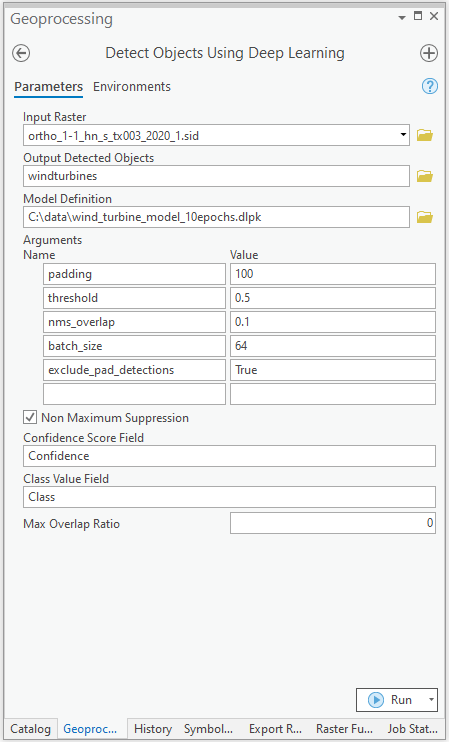

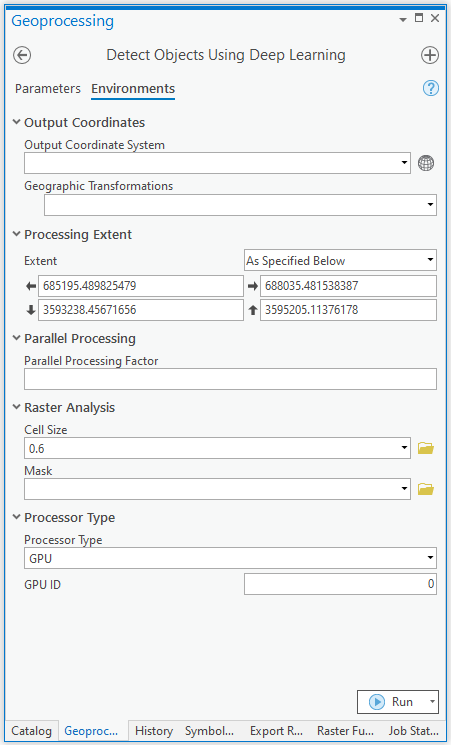

You can also achieve this using arcpy.

```python
with arcpy.EnvManager(
    extent="685195.489825479 3593238.45671656 688035.481538387 3595205.11376178", 
    cellSize=0.6, 
    processorType="GPU"
):
    arcpy.ia.DetectObjectsUsingDeepLearning(
        "ortho_1-1_hn_s_tx003_2020_1.sid", 
        r"C:\data\wind_turbines.shp", 
        r"C:\data\wind_turbine_model_10epochs.dlpk", 
        "padding 100;threshold 0.5;nms_overlap 0.1;batch_size 64;exclude_pad_detections True", 
        "NMS", 
        "Confidence", 
        "Class", 
        0, 
        "PROCESS_AS_MOSAICKED_IMAGE"
    )
```

The output of this model is a layer of detected wind turbines, as show below.

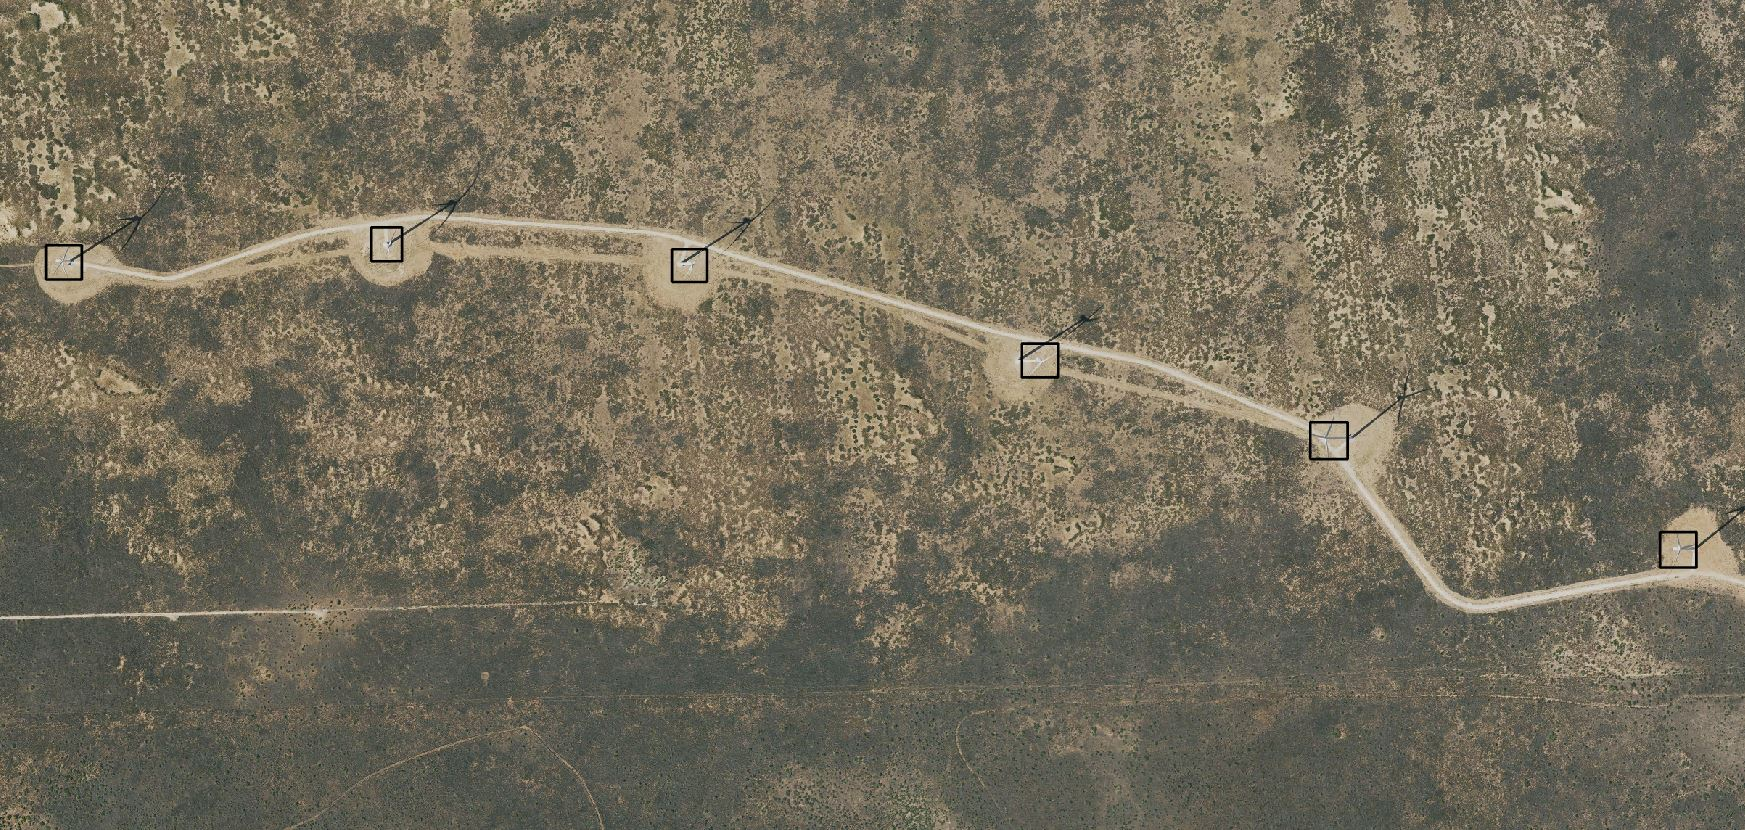

<center>A subset of detected wind turbines.

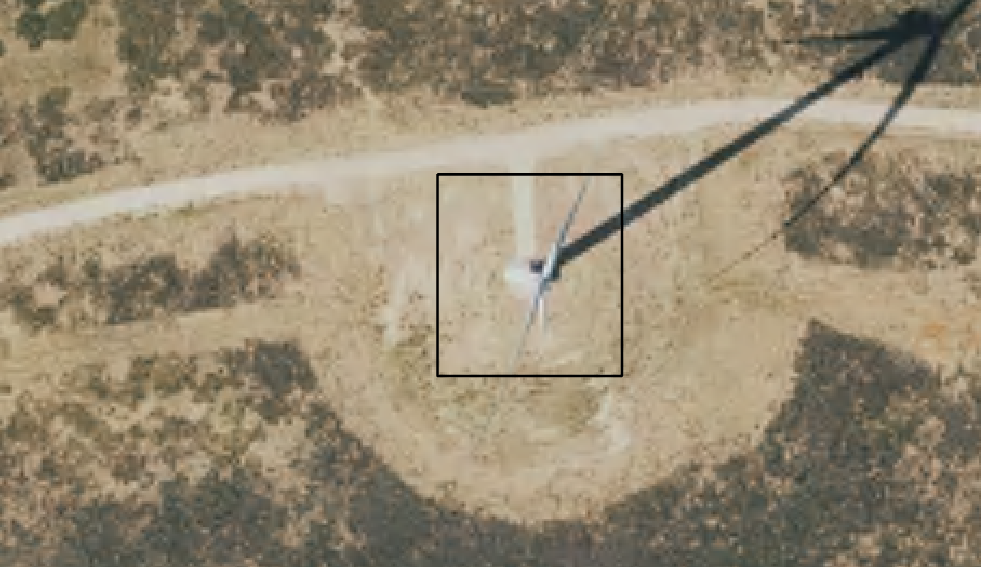

<center>A single wind turbine.

## Conclusion

This notebook has demonstrated a workflow to train a deep learning model that detects features representing wind turbines. This notebook uses multiprocessing to reduce the time required to export training data. In this notebook, we also leveraged multiple GPUs to reduce the time for model training. We can follow a similar approach to classify other objects of interest, like trees, buildings, structures, etc.